# Softmax - MNIST

En este notebook vamos a ver la implementación de Softmax en NumPy para clasificación multiclase. Vamos a aplicar el modelo al dataset de dígitos escritos a mano de la clase 2. 

## Cargamos las Librerías

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools
import random

RANDOM_STATE = 17

In [2]:
# Importar trabajos previos
import sys  
# sys.path.insert(0, '../../clase_3/ejercicios/src')
# from models import BaseModel
# from metrics import Accuracy, Precision, Recall

## Cargamos el Dataset

In [3]:
# Cargamos los datos
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [4]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


In [5]:
clases = np.unique(y)
print(clases)

[0 1 2 3 4 5 6 7 8 9]


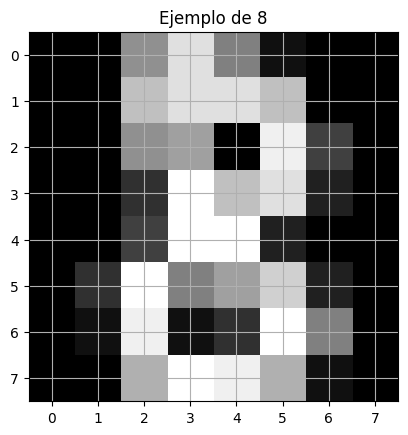

In [6]:
# Cargamos una muestra

plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')
plt.show()

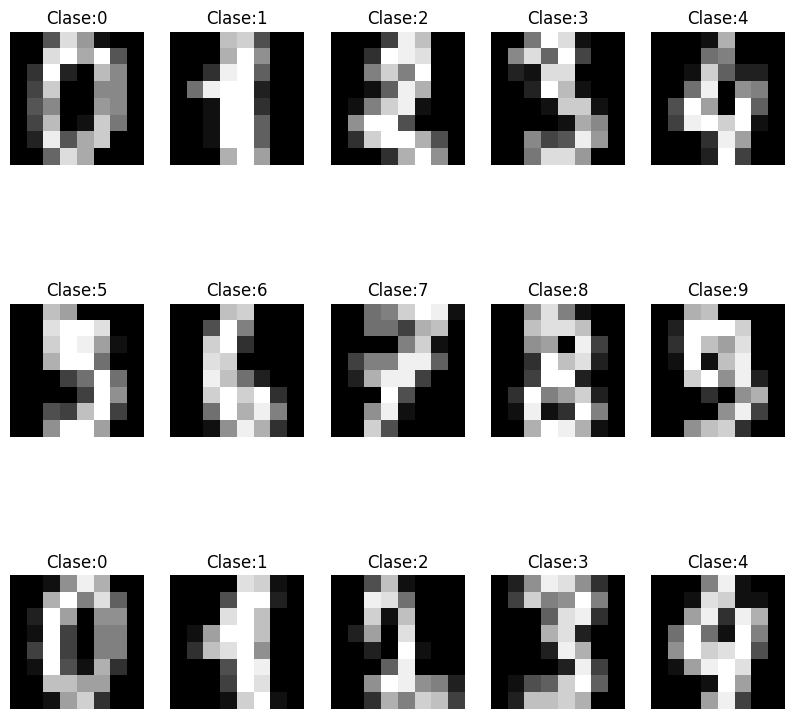

In [7]:
# Graficamos varias muestras

fig = plt.figure(figsize=(10, 10))
for i in range(15):  
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(X[i].reshape(8, 8), cmap=plt.get_cmap('gray'))
    ax.set_title('Clase:{y}'.format(y=y[i]))
    plt.axis('off')
plt.show()

In [8]:
# Split del dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [9]:
X_train.shape

(1437, 64)

In [10]:
y_train.shape

(1437,)

## Creamos el Modelo

In [11]:
class Softmax():

    def fit(self, X, y, epochs, lr, batchSize, alpha, verbose=True, log=50):
        
        """
        shapes:
            X ==> n*m
            y ==> n*c
            W ==> m*c
        """
        
        # inicializamos aleatoriamente los pesos

        n = X.shape[0] # numero de muestras
        m = X.shape[1] # numero de features
        c = np.unique(y).shape[0] # numero de clases

        self.model = 0.001 * np.random.rand(m, c)
        
        # Inicializamos el término de velocidad (comprende el momento + gradiente de epoch)
        #self.velocity = np.zeros_like(self.model)
        
        y_hot = self.OneHotEncoding(y)
        
        train_loss = []

        for i in range(epochs):
            loss = self.MiniBatchGD(X, y_hot, lr, batchSize, alpha)
            train_loss.append(loss)
        
            if verbose:
                if i%log==0:
                    print("Epoch: {}, Loss: {}".format(i, loss))

        return train_loss

    def MiniBatchGD(self, X, y, lr, batchSize, alpha):
        
        losses = []
        
        # Hcemos un shuffle de los datos
        idx = random.sample(range(X.shape[0]), X.shape[0])
        X = X[idx]
        y = y[idx]
        
        for i in range(0, X.shape[0], batchSize):
            batch_X = X[i:i+batchSize]
            batch_y = y[i:i+batchSize]
            
            loss, dw = self.computeLoss(batch_X, batch_y, alpha)
            
            #self.velocity = (momentum * self.velocity) + (lr * dw)
            
            self.model = self.model - lr * dw
            
            losses.append(loss)
        
        return np.mean(losses)
    
    def softmaxEquation(self, z):
        
        # Restamos el máximos por estabilidad numérica
        z -= np.max(z)
        
        prob = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
        
        return prob
    

    def computeLoss(self, X, y, alpha):
        
        n = X.shape[0]
        
        # Calculamos el linear mapping y las predicciones con softmax
        z = np.dot(X, self.model)
        predictions = self.softmaxEquation(z)

        # Calculamos el loss total (modelo + regularización)
        # Modelo
        loss = -np.log(np.max(predictions)) * y
        # Regularización
        reg_loss = (1/2) * alpha * np.sum(self.model * self.model)
        # total
        total_loss = (np.sum(loss) / n) + reg_loss
        
        # Calculamos el gradiente
        gradient = ((-1 / n) * np.dot(X.T, (y - predictions))) + (alpha * self.model)
        
        return total_loss, gradient

    
    def OneHotEncoding(self, y):
        
        """
        shapes:
            y     --> nx1 
            y_hot --> nxc
            c = cantidad de clases    
        """    
        c = np.unique(y).shape[0]

        # matriz de ceros de nxc
        y_hot = np.zeros((len(y), c))

        # indexamos con el valor de y (0,1,...,9) y colocamos un 1
        y_hot[np.arange(len(y)), y] = 1

        return y_hot
    

    def predict(self, X):
        return np.argmax(X.dot(self.model), axis=1)


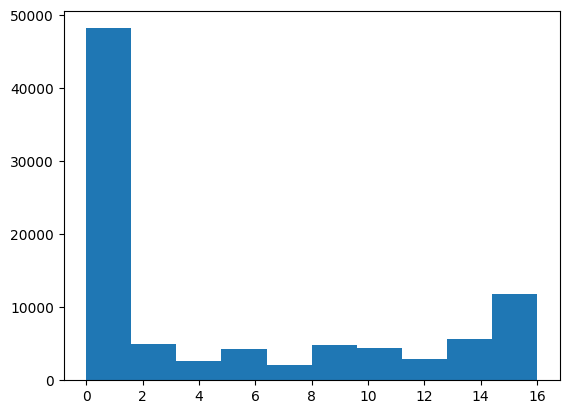

In [12]:
f, ax = plt.subplots()

ax.hist(X_train.flatten())

plt.show()

In [13]:
np.max(X_train)

16.0

In [14]:
# Escalamos las features

X_train_s = X_train / 16
X_test_s = X_test / 16

In [15]:
# Seleccionar hiperparámetros

lr = 0.01 # Learning rate
batchSize = 10 # Tamaño de los minibatch
epochs = 1000 # Epochs de entrenamiento
alpha = 0.001 # Peso de la regularización

In [16]:
softmax_clf = Softmax()

train_loss = softmax_clf.fit(X_train_s, y_train, epochs=epochs, lr=lr, batchSize=batchSize, alpha=alpha)

Epoch: 0, Loss: 2.0505250723007302
Epoch: 50, Loss: 0.09671358601927431
Epoch: 100, Loss: 0.0879182090137538
Epoch: 150, Loss: 0.09488529878947129
Epoch: 200, Loss: 0.10140295092497134
Epoch: 250, Loss: 0.10682196171066602
Epoch: 300, Loss: 0.11013064205581384
Epoch: 350, Loss: 0.11329832353477383
Epoch: 400, Loss: 0.11581066652805252
Epoch: 450, Loss: 0.1188153199650066
Epoch: 500, Loss: 0.12010796850439413
Epoch: 550, Loss: 0.12110618771313389
Epoch: 600, Loss: 0.12237124250221987
Epoch: 650, Loss: 0.12388551397671607
Epoch: 700, Loss: 0.12484874503654031
Epoch: 750, Loss: 0.1255106907132938
Epoch: 800, Loss: 0.12645992410996312
Epoch: 850, Loss: 0.1263767825158677
Epoch: 900, Loss: 0.12717888424063428
Epoch: 950, Loss: 0.1272332910379779


### Predicciones y Matriz de Confusión

In [17]:
def getConfusionMatrix(truth, prediction, c):

    conf_mtx =[]
    
    for _ in range(c):
        conf_mtx.append([])
        for _ in range(c):
            conf_mtx[-1].append(0)

    for i in range(truth.shape[0]):
        conf_mtx[int(truth[i])][int(prediction[i])] += 1
    
    conf_mtx = np.array(conf_mtx)
    
    conf_mtx = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis]
    
    return conf_mtx

In [18]:
def plotConfusionMatrix(conf_mtx, c):
    plt.figure(figsize=(15,15))
    plt.imshow(conf_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(c)
    plt.xticks(tick_marks, np.arange(c) , rotation=45)
    plt.yticks(tick_marks, np.arange(c))

    fmt = '.2f'
    thresh = conf_mtx.max() / 2.

    for i, j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j, i, format(conf_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mtx[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [19]:
predictions = softmax_clf.predict(X_test_s)

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
accuracy_score(y_test, predictions)

0.9638888888888889

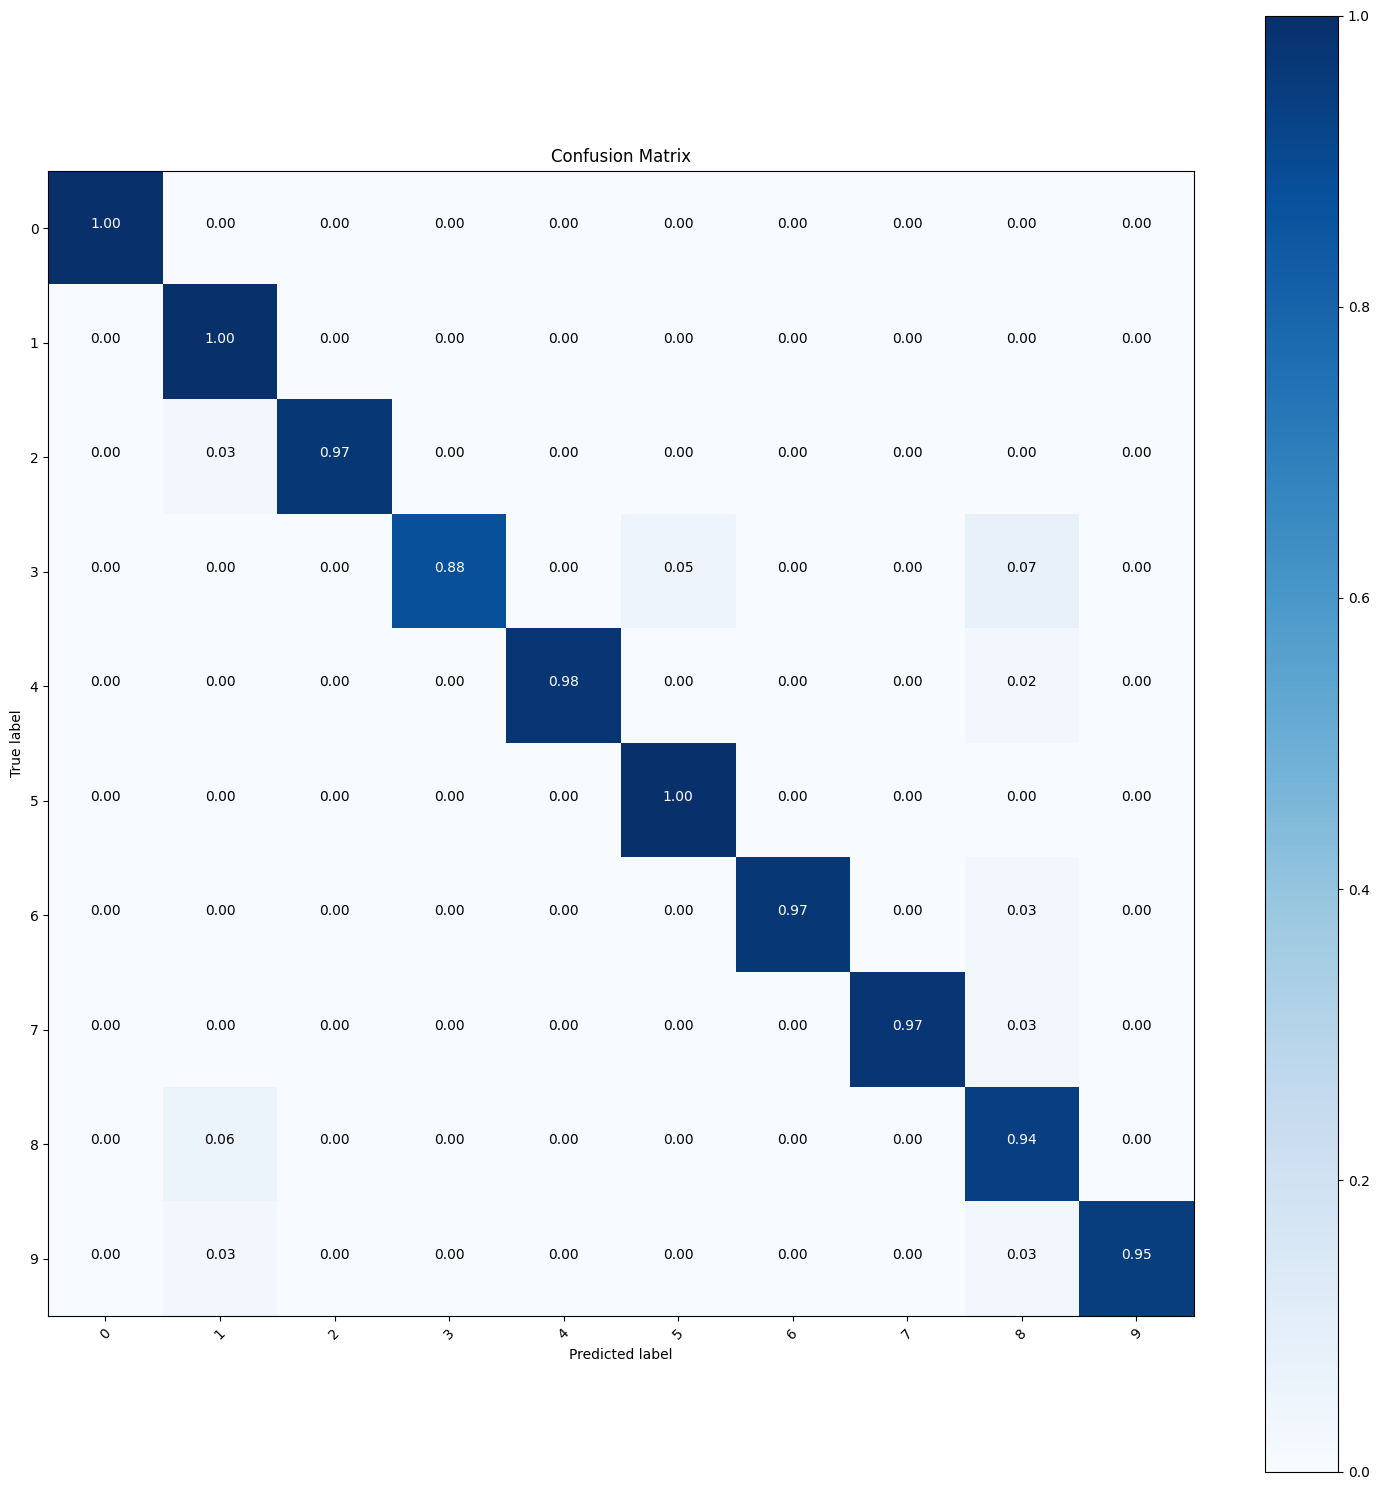

In [22]:
conf_mtx = getConfusionMatrix(y_test, predictions, 10)
plotConfusionMatrix(conf_mtx, 10)

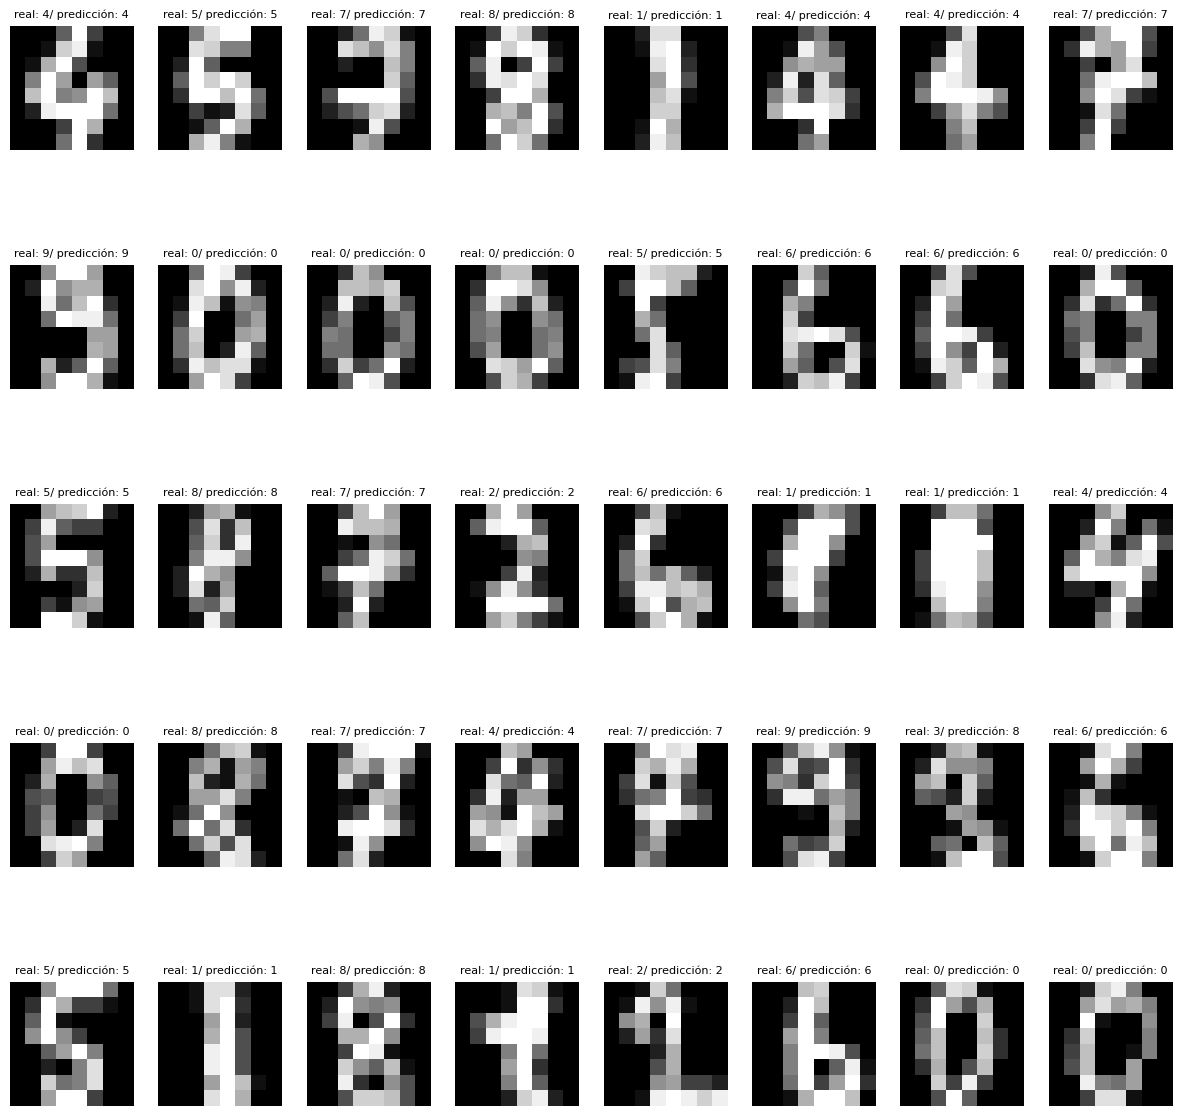

In [23]:
fig = plt.figure(figsize=(15,15))

for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(X_test[i].reshape(8, 8), cmap=plt.get_cmap('gray'))    
    ax.set_title('real: {y}/ predicción: {y_hat}'.format(y=y_test[i], y_hat=predictions[i]), fontsize=8)
    plt.axis('off')